# Democratie et citoyennete

Topic mining analysis on Data from 'Le Grand debat' https://granddebat.fr

Using LDA from the gensim package and displayed with pyLDAvis package

In [6]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

import pickle

import importlib
import utils.proc_func as proc_func
importlib.reload(proc_func)

<module 'utils.proc_func' from 'C:\\Users\\ben.vdb\\Documents\\Github\\GrandDebat\\utils\\proc_func.py'>

In [2]:
# NLTK Stop words in french

from nltk.corpus import stopwords
stop_words = stopwords.words('french')
stop_words.extend(['plus', 'faire', 'tout', 'oui', 'non'])
print(stop_words)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load('fr', disable=['parser', 'ner'])
spacy_nlp = spacy.load('fr_core_news_md')
# spacy stopwords
spacy_stopwords = spacy.lang.fr.stop_words.STOP_WORDS
# print(spacy_stopwords)

# combine both lists
#stop_words.extend(spacy_stopwords)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'je', 'la', 'le', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras', 'aura', 'aurons', 'aurez', 'auront',

In [3]:
# Import Dataset and select the free field questions

df = pd.read_csv('C:/Users/ben.vdb/Documents/Data/GrandDebat/DEMOCRATIE_ET_CITOYENNETE.csv')
pprint(df.columns)


Index(['reference', 'title', 'createdAt', 'publishedAt', 'updatedAt',
       'trashed', 'trashedStatus', 'authorId', 'authorType', 'authorZipCode',
       'En qui faites-vous le plus confiance pour vous faire représenter dans la société et pourquoi ?',
       'En dehors des élus politiques, faut-il donner un rôle plus important aux associations et aux organisations syndicales et professionnelles ?',
       'Si oui, à quel type d'associations ou d'organisations ? Et avec quel rôle ?',
       'Que faudrait-il faire pour renouer le lien entre les citoyens et les élus qui les représentent ?',
       'Le non-cumul des mandats instauré en 2017 pour les parlementaires (députés et sénateurs) est :',
       'Pourquoi ?',
       'Que faudrait-il faire pour mieux représenter les différentes sensibilités politiques ?',
       'Pensez-vous qu'il serait souhaitable de réduire le nombre d'élus (hors députés et sénateurs) ?',
       'Si oui, lesquels ?',
       'Que pensez-vous de la participation des

In [4]:
# selected questions
questions = [x for x in range(10,len(df.columns)) if x not in [11,14,15,17,20,23,27,39]]
pprint(list(df.columns[questions]))

['En qui faites-vous le plus confiance pour vous faire représenter dans la '
 'société et pourquoi ?',
 "Si oui, à quel type d'associations ou d'organisations ? Et avec quel rôle ?",
 'Que faudrait-il faire pour renouer le lien entre les citoyens et les élus '
 'qui les représentent ?',
 'Que faudrait-il faire pour mieux représenter les différentes sensibilités '
 'politiques ?',
 'Si oui, lesquels ?',
 'Que pensez-vous de la participation des citoyens aux élections et comment '
 'les inciter à y participer davantage ?',
 'Si oui, de quelle manière ?',
 "Que faudrait-il faire aujourd'hui pour mieux associer les citoyens aux "
 'grandes orientations et à la décision publique ? Comment mettre en place une '
 'démocratie plus participative ?',
 'Si oui, comment ?',
 'Que faudrait-il faire pour consulter plus directement les citoyens sur '
 "l'utilisation de l'argent public, par l'Etat et les collectivités ?",
 'Quel rôle nos assemblées, dont le Sénat et le Conseil économique, social et '


En qui faites-vous le plus confiance pour vous faire représenter dans la société et pourquoi ?


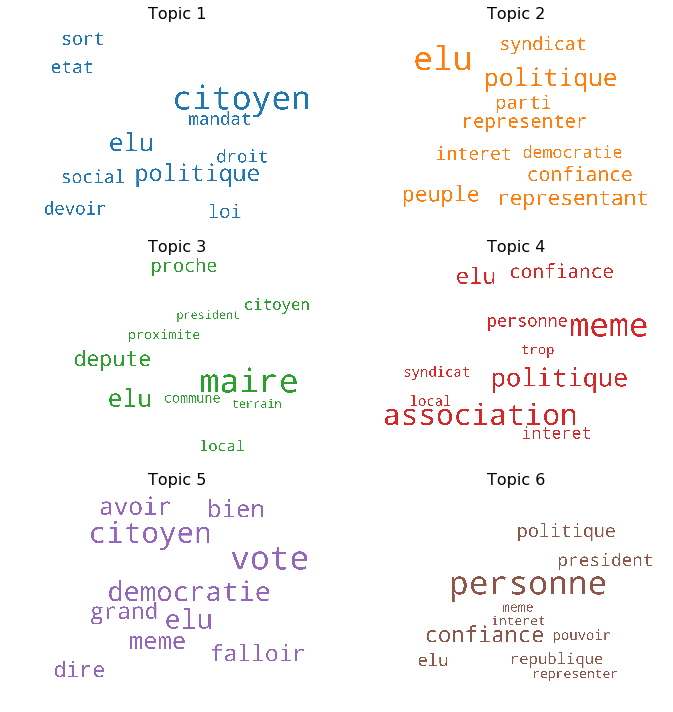

Si oui, à quel type d'associations ou d'organisations ? Et avec quel rôle ?


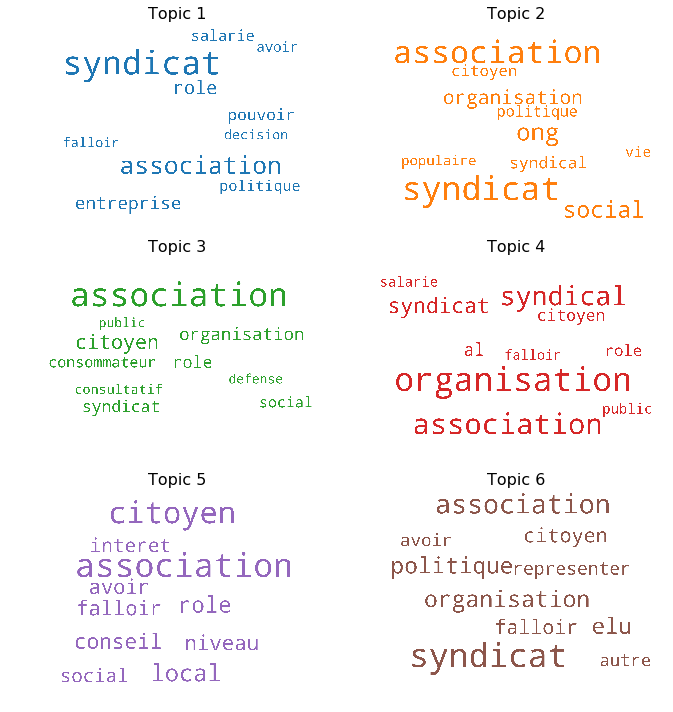

Que faudrait-il faire pour renouer le lien entre les citoyens et les élus qui les représentent ?


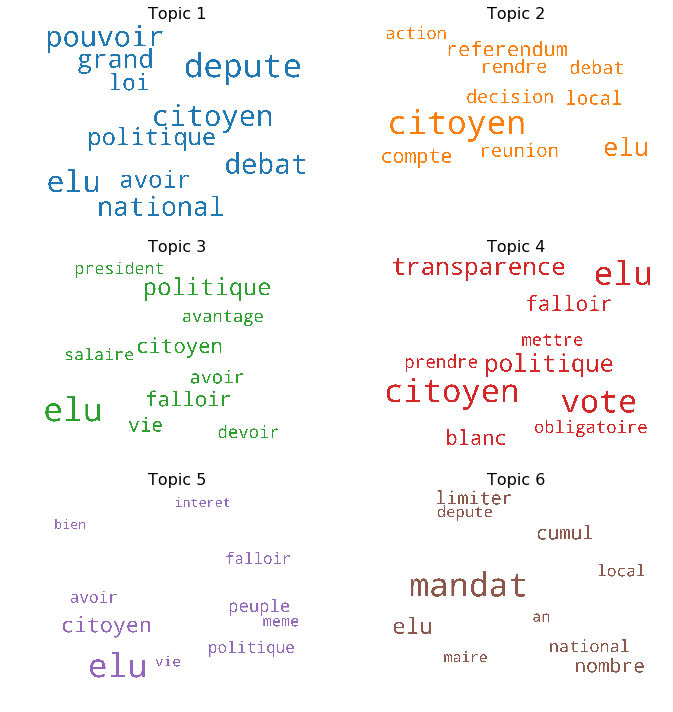

Que faudrait-il faire pour mieux représenter les différentes sensibilités politiques ?


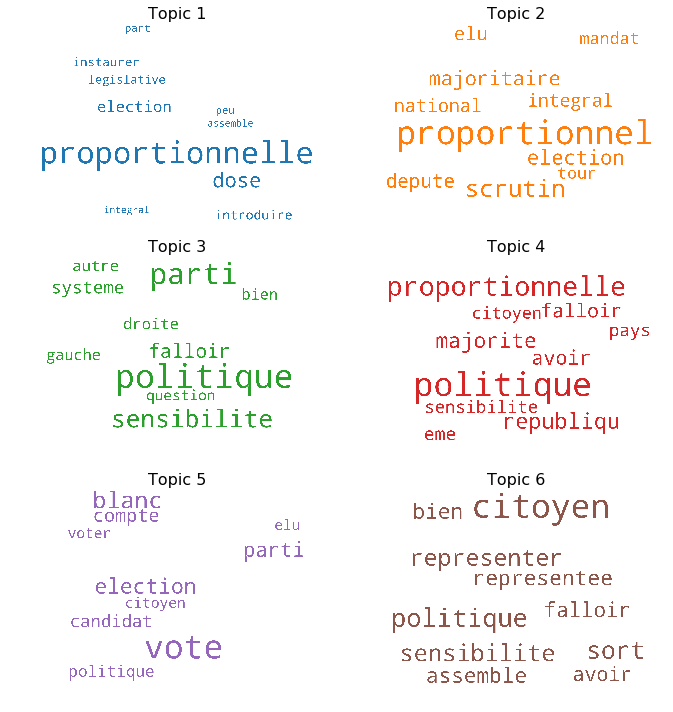

Si oui, lesquels ?


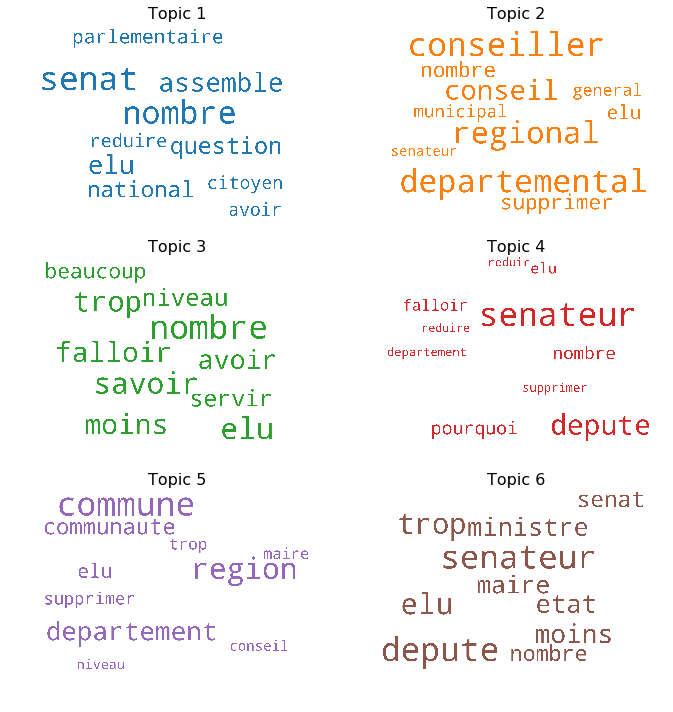

Que pensez-vous de la participation des citoyens aux élections et comment les inciter à y participer davantage ?


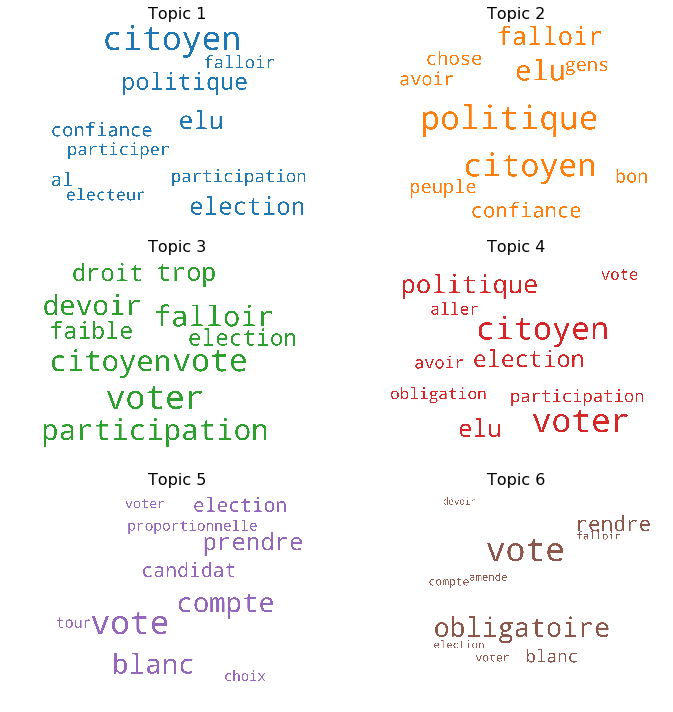

Si oui, de quelle manière ?


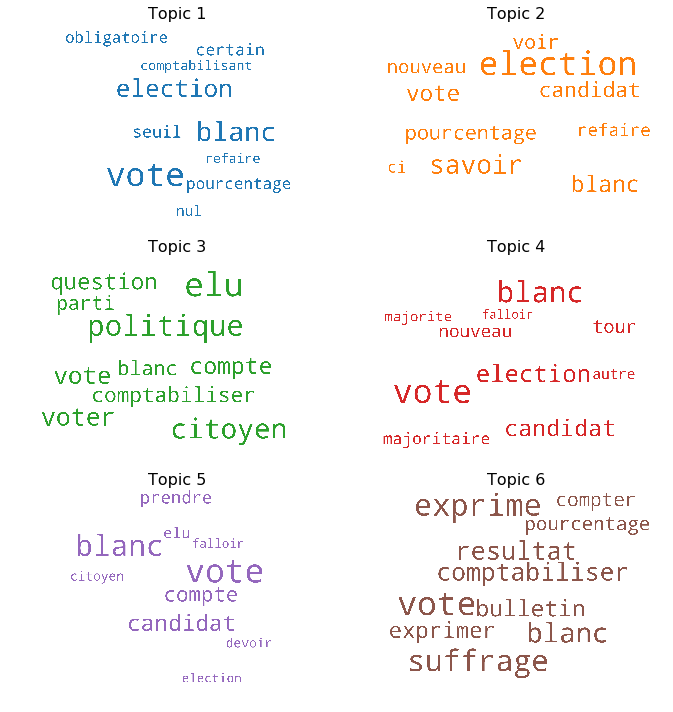

Que faudrait-il faire aujourd'hui pour mieux associer les citoyens aux grandes orientations et à la décision publique ? Comment mettre en place une démocratie plus participative ?


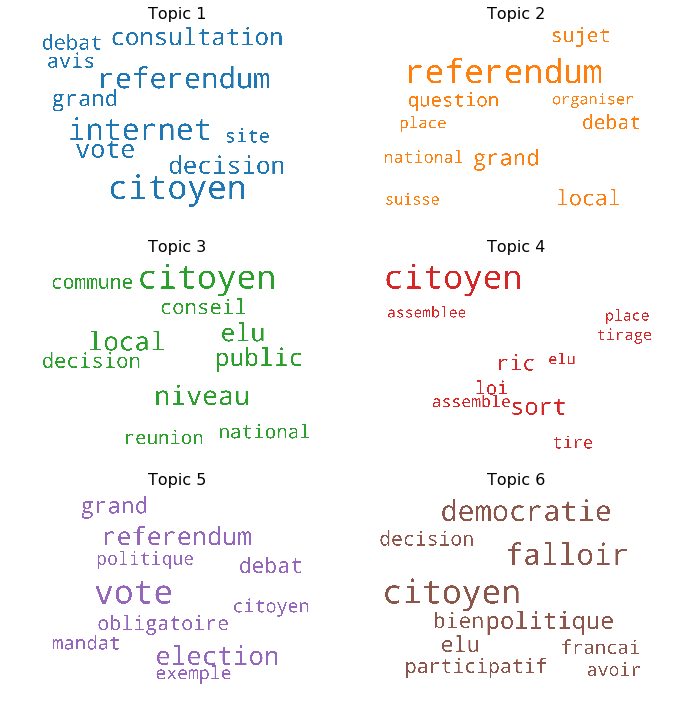

Si oui, comment ?


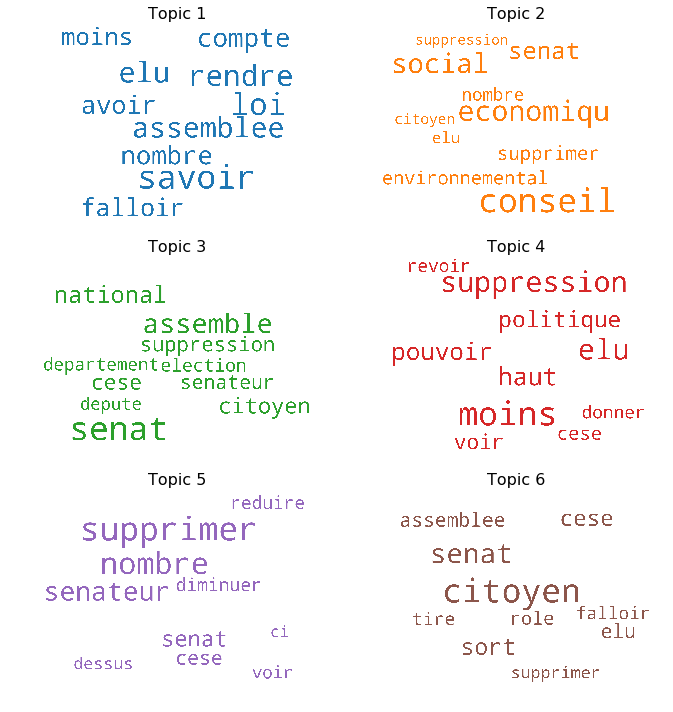

Que faudrait-il faire pour consulter plus directement les citoyens sur l'utilisation de l'argent public, par l'Etat et les collectivités ?


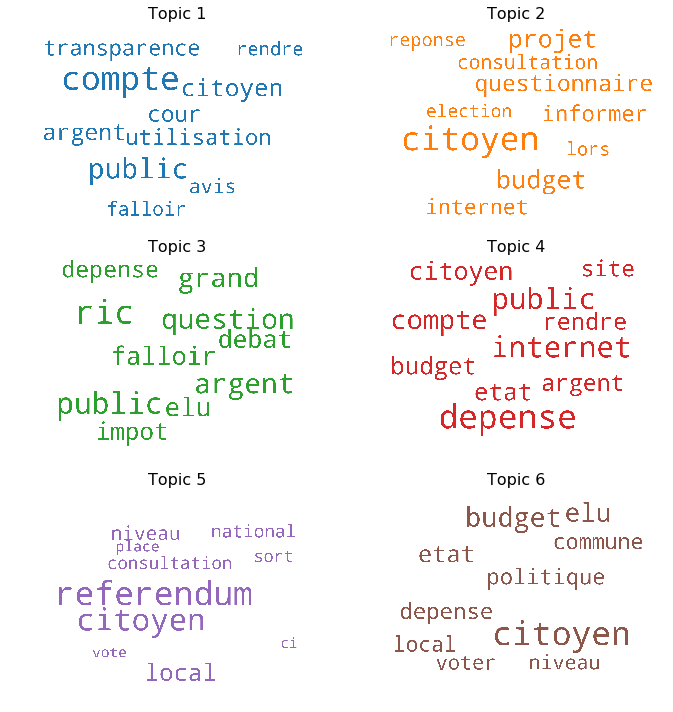

Quel rôle nos assemblées, dont le Sénat et le Conseil économique, social et environnemental, doivent-elles jouer pour représenter nos territoires et la société civile ?


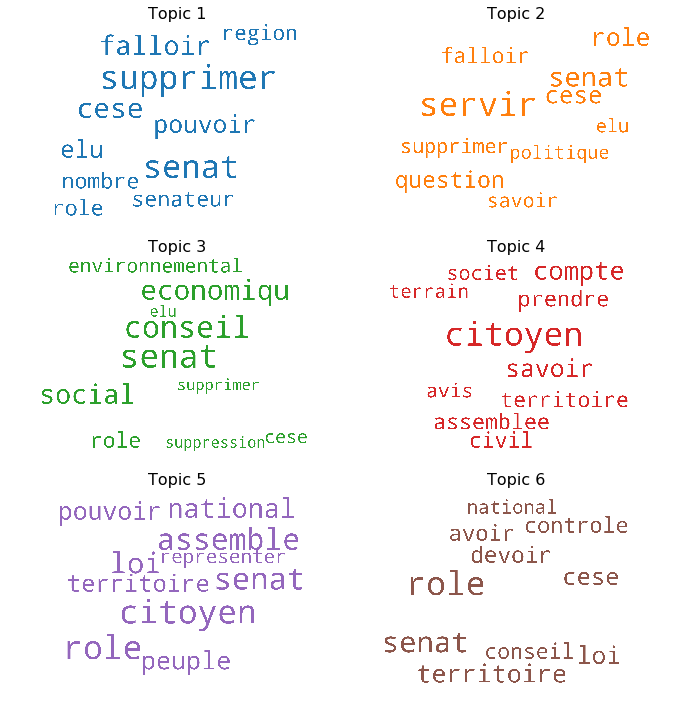

Que proposez-vous pour renforcer les principes de la laïcité dans le rapport entre l'Etat et les religions de notre pays ?


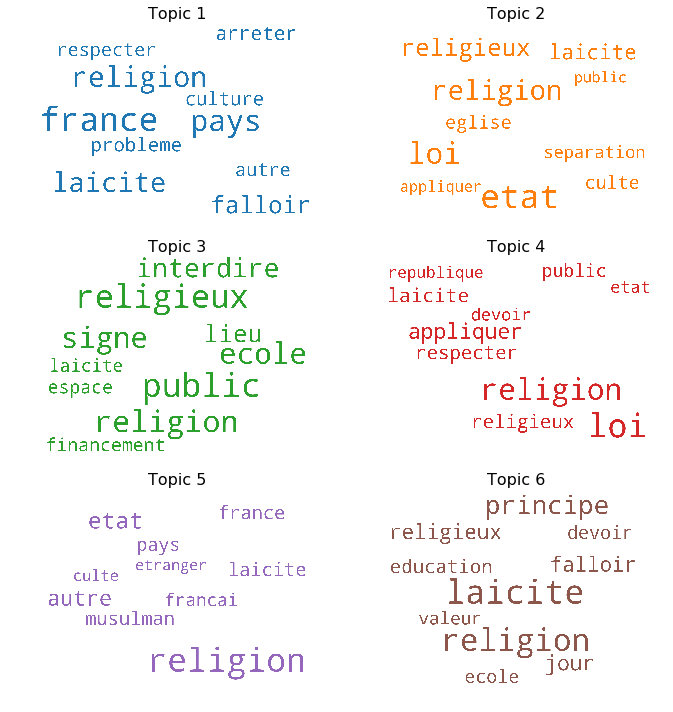

Comment garantir le respect par tous de la compréhension réciproque et des valeurs intangibles de la République ?


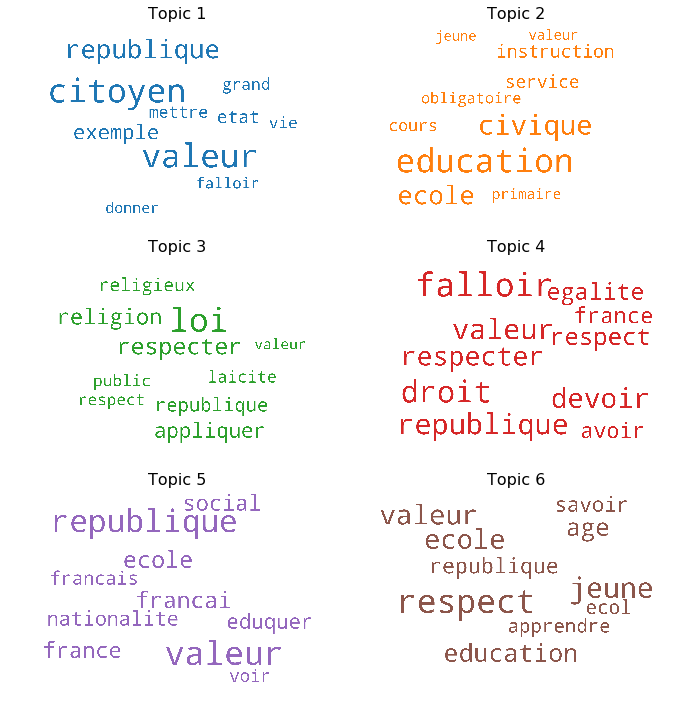

Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?


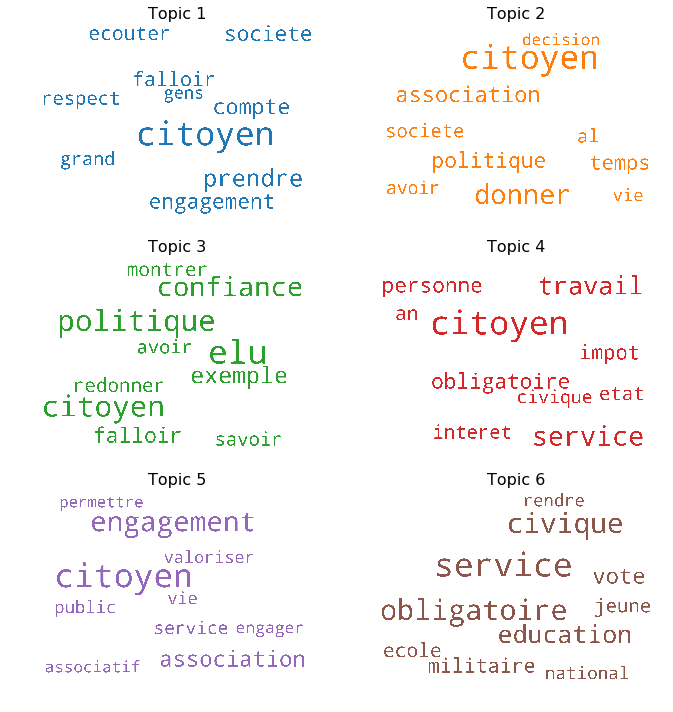

Quels sont les comportements civiques qu'il faut promouvoir dans notre vie quotidienne ou collective ?


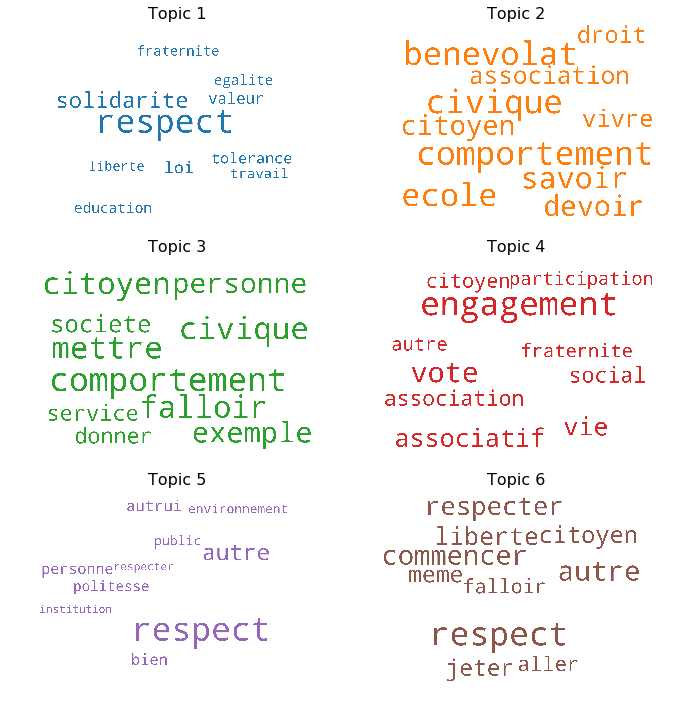

Que faudrait-il faire pour favoriser le développement de ces comportements civiques et par quels engagements concrets chacun peut-il y participer ?


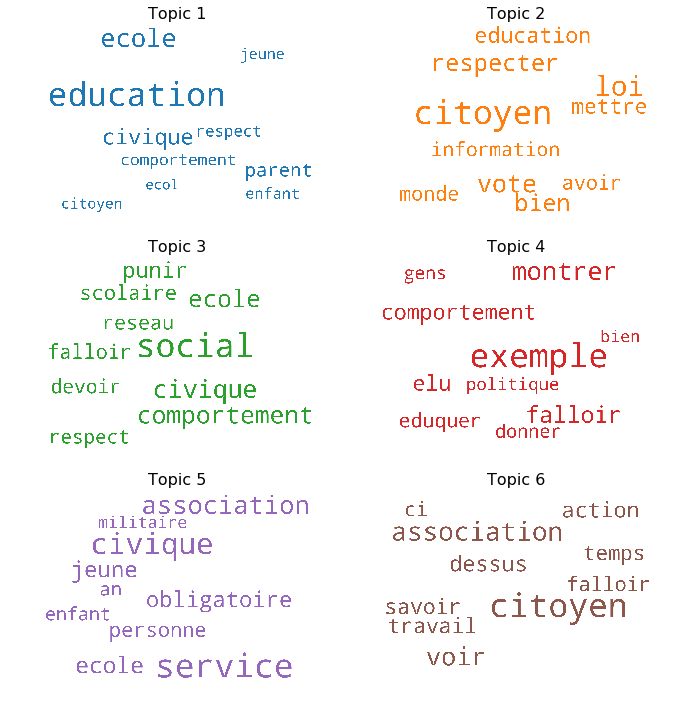

Que faudrait-il faire pour valoriser l'engagement citoyen dans les parcours de vie, dans les relations avec l'administration et les pouvoirs publics ?


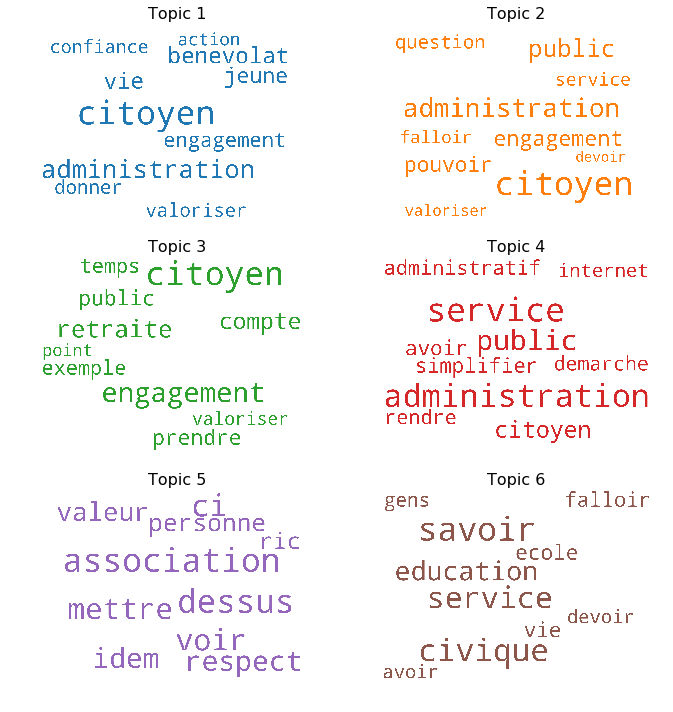

Quelles sont les incivilités les plus pénibles dans la vie quotidienne et que faudrait-il faire pour lutter contre ces incivilités ?


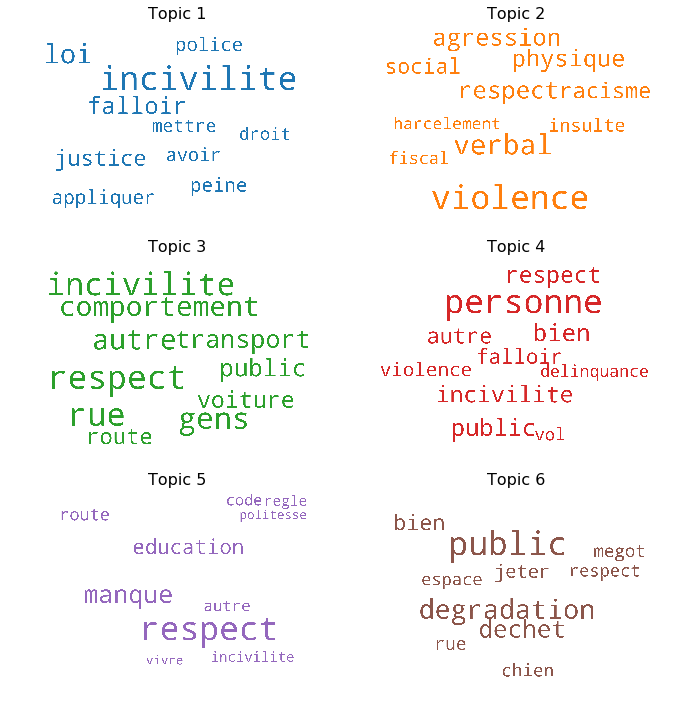

Que peuvent et doivent faire les pouvoirs publics pour répondre aux incivilités ?


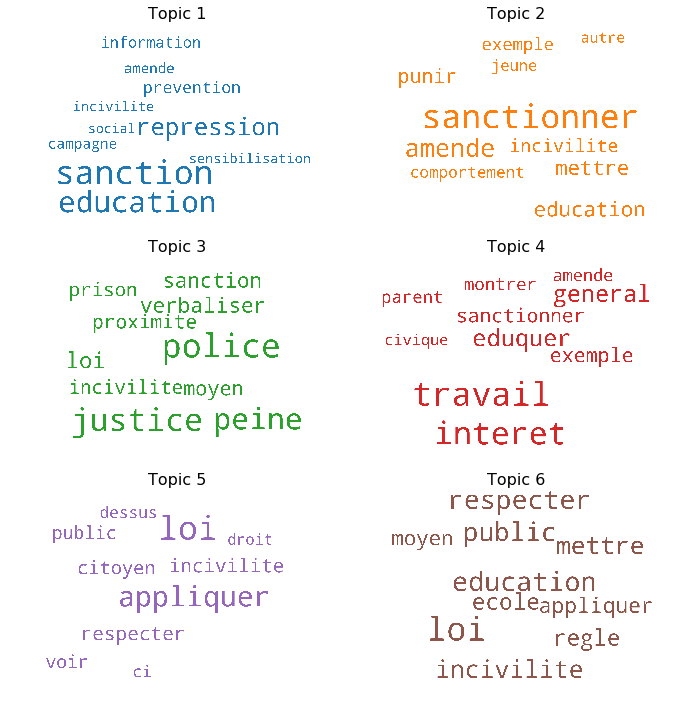

Quel pourrait être le rôle de chacun pour faire reculer les incivilités dans la société ?


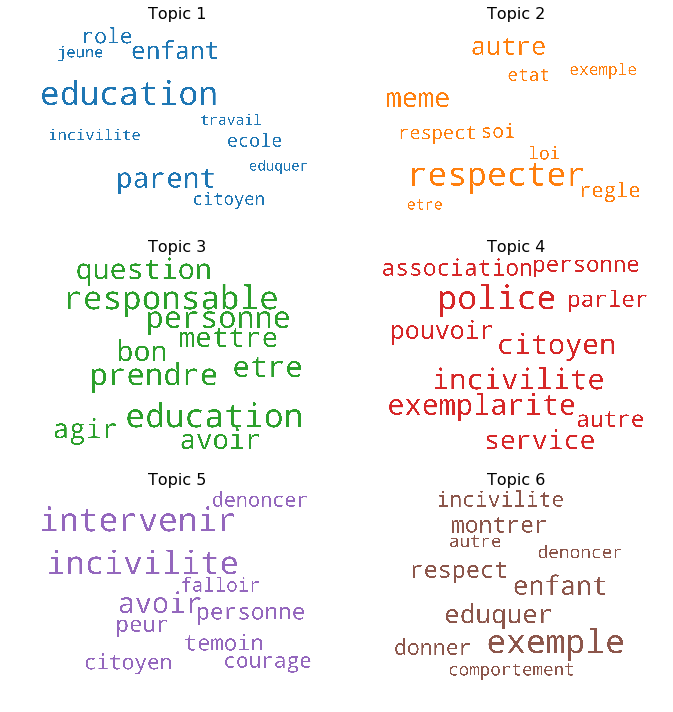

Quelles sont les discriminations les plus répandues dont vous êtes témoin ou victime ?


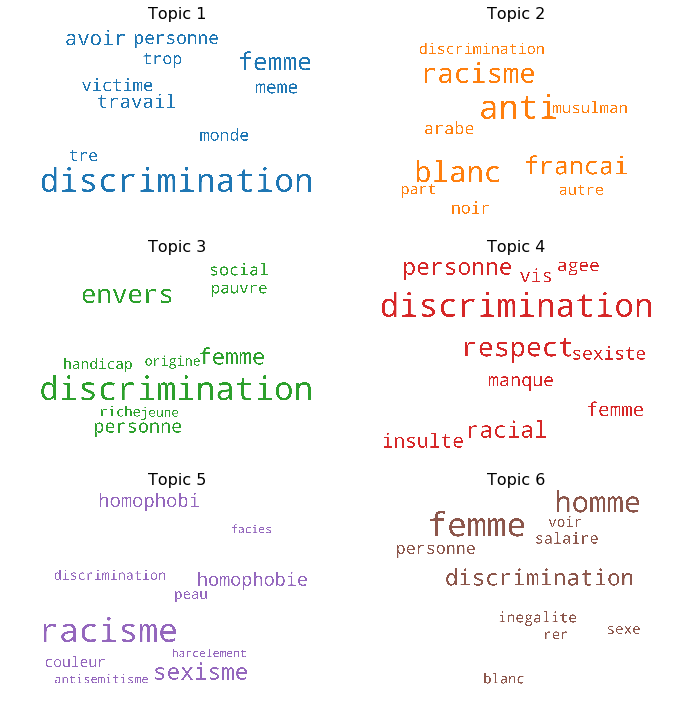

Que faudrait-il faire pour lutter contre ces discriminations et construire une société plus solidaire et plus tolérante ?


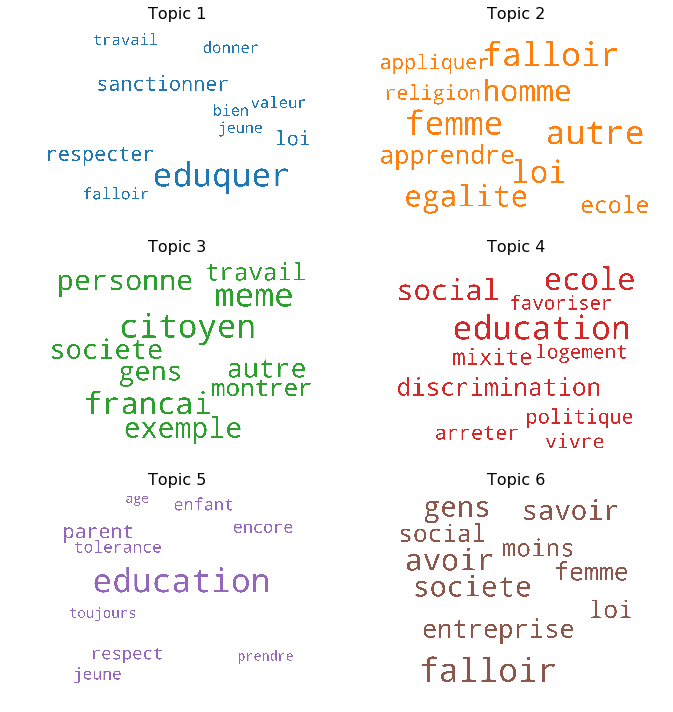

Si oui, lesquelles ?


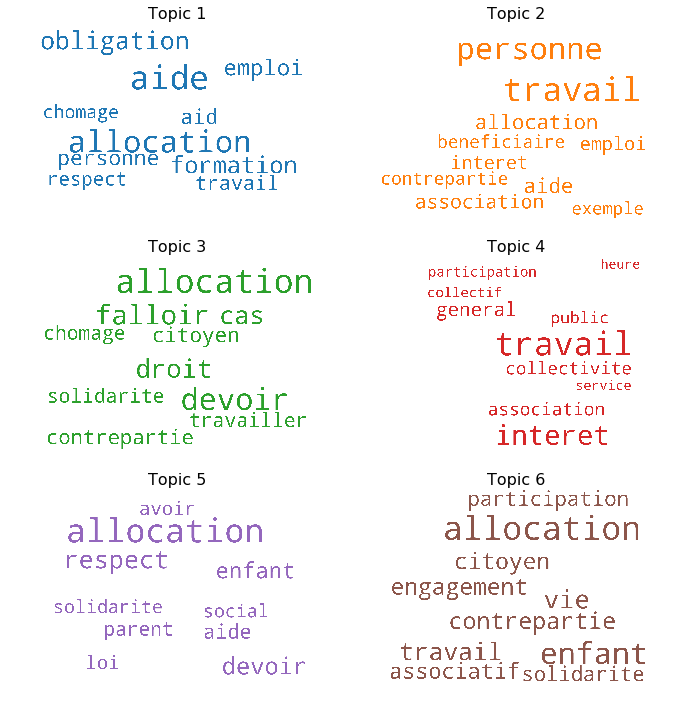

Que pensez-vous de la situation de l'immigration en France aujourd'hui et de la politique migratoire ? Quelles sont, selon vous, les critères à mettre en place pour définir la politique migratoire ?


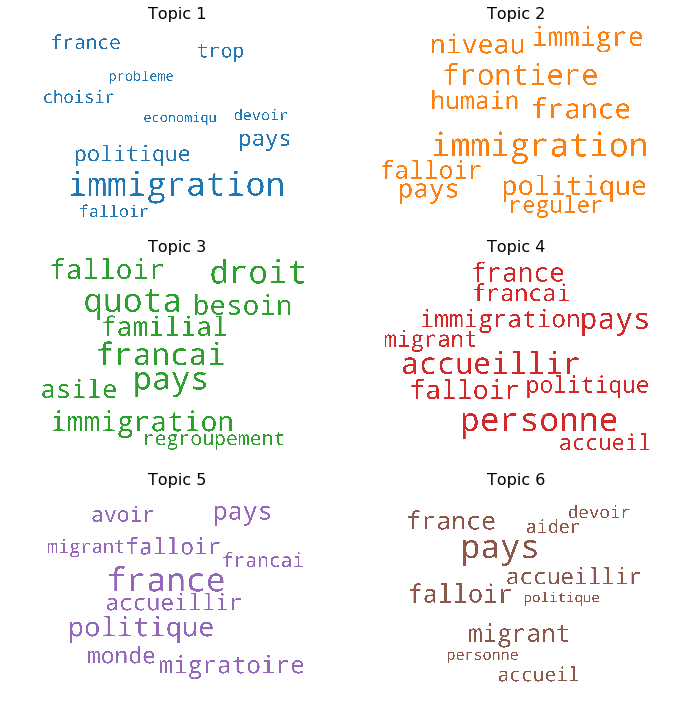

En matière d'immigration, une fois nos obligations d'asile remplies, souhaitez-vous que nous puissions nous fixer des objectifs annuels définis par le Parlement ?


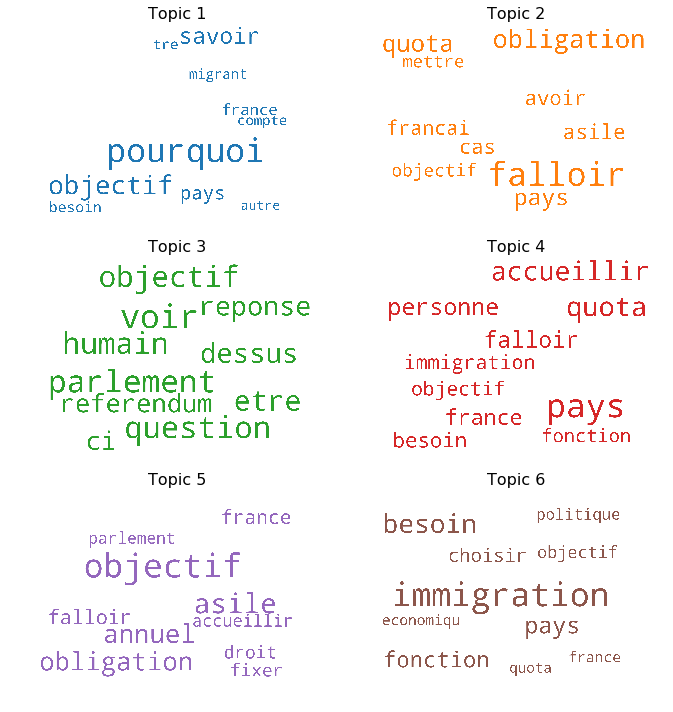

Que proposez-vous afin de répondre à ce défi qui va durer ?


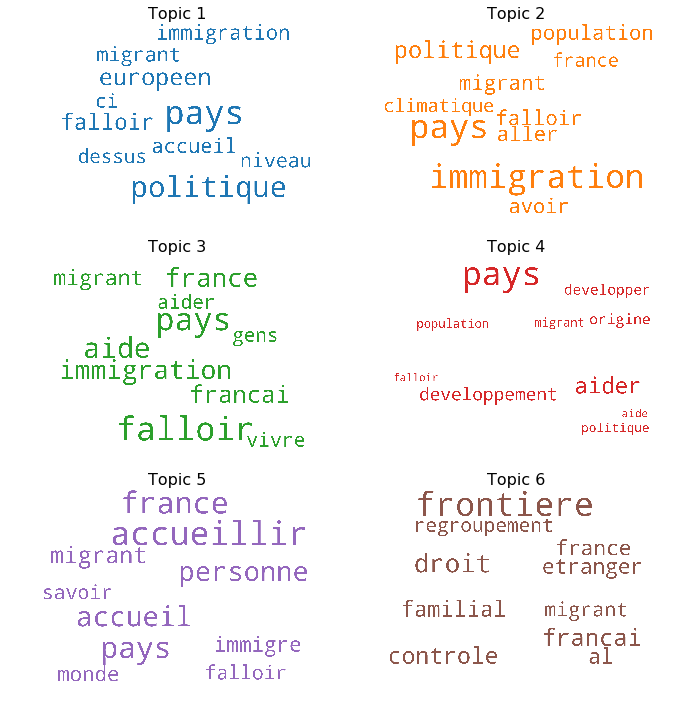

Quelles sont, selon vous, les modalités d'intégration les plus efficaces et les plus justes à mettre en place aujourd'hui dans la société ?


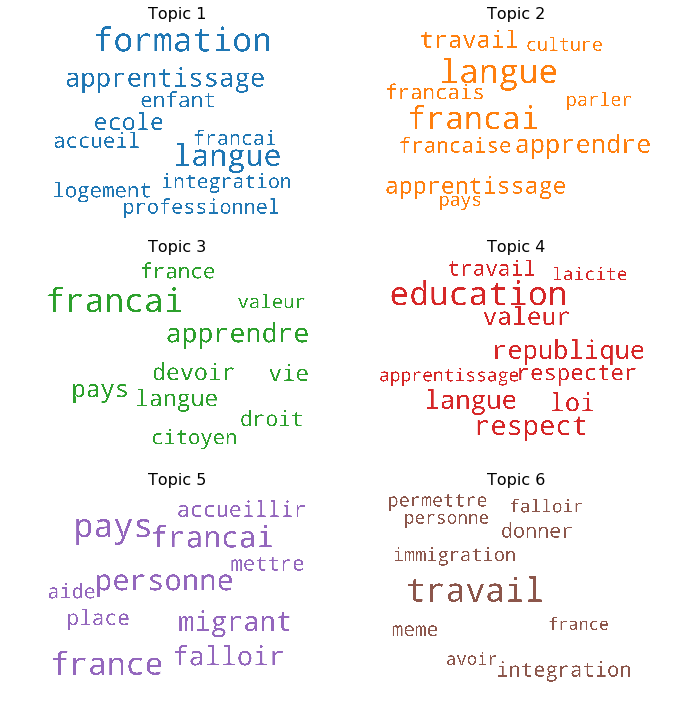

Y a-t-il d'autres points sur la démocratie et la citoyenneté sur lesquels vous souhaiteriez vous exprimer ?


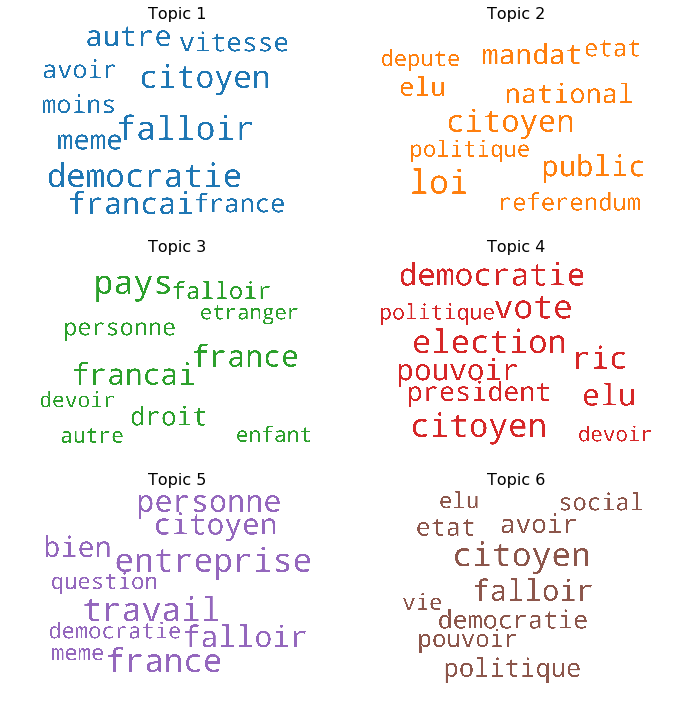

In [7]:
# Loop over the questions and fit a model of 6 topics for each

question_text = []
num_topics = 6
model_list = []
data_lemma = []
LDAvis = []
doc_scored = []
first = 0

for q in range(first, len(questions)):
    print(df.columns[questions[q]])
    question_text.append(df.columns[questions[q]])
    
    # Selecting the column, removing NAs
    data = df.iloc[:,questions[q]].dropna().values.tolist()
#     # Remove Emails
#     data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
#     # Remove new line characters
#     data = [re.sub('\s+', ' ', sent) for sent in data]
#     # Remove distracting single quotes
#     data = [re.sub("\'", " ", sent) for sent in data]
#     data = [re.sub("\’", " ", sent) for sent in data]
    
    # Initual cleaning, tokenisation and cleaning special characters and punctuation (gensim simple prepocess)
    data_words = list(proc_func.sent_to_words(data))
    
    # Do lemmatization with spacy keeping only noun, adj, vb, adv
    data_lemmatized = proc_func.lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
        
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_lemmatized, min_count=3, threshold=50) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=50)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Form Bigrams
    data_words_bigrams = [bigram_mod[doc] for doc in data_lemmatized]
    
    # Remove Stop Words
    data_words_nostops = proc_func.remove_stopwords(data_lemmatized)
    
    data_lemma.append(data_words_nostops)

    # save data lemmatized
    pickle.dump(data_lemma[q-first], open('./lda_models/data_lemma_democratie'+ str(q) +'.pkl', 'wb'))
        
    # Create Dictionary
    id2word = corpora.Dictionary(data_words_nostops)

    # Create Corpus
    texts = data_words_nostops

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Fit the LDA model with gensim for a number of predifined topics
    model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           passes=10,
                                           per_word_topics=True)
    model_list.append(model)
    # save the model
    model_list[q-first].save('./lda_models/model_democratie'+ str(q) +'.gensim')
    
    # score each document and merge back the id
    df_topic_sents_keywords = proc_func.format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts)
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    
    doc_scored.append(pd.concat([df.iloc[:,[7,questions[q]]].dropna().reset_index(drop=True), df_dominant_topic], axis=1))
    pickle.dump(doc_scored[q-first], open('./lda_models/doc_scored_democratie'+ str(q) +'.pkl', 'wb'))
    
    # Visualize the topics with LDAvis
#     pyLDAvis.enable_notebook()
#     vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
#     vis
#     LDAvis.append(vis)
#     pyLDAvis.save_html(LDAvis[q],'./lda_vis/model_ecolo'+ str(q) +'.html')
    
    # Visualize WordCloud
    proc_func.cloud6topics(stop_words,model)
    

In [8]:
# load the scored documents, keep Id, scored topic and keyword, save 

first = 0
democratie_scored = df[['authorId']].drop_duplicates() #   pd.DataFrame(columns=['authorId'])
score = pd.DataFrame()
democratie_topics = pd.DataFrame()
democratie_topicst = pd.DataFrame()

for q in range(first, len(questions)):
#     score = pickle.load(open('./lda_models/doc_scored_democratie'+ str(q) +'.pkl', 'rb'))
    score = pd.read_pickle('./lda_models/doc_scored_democratie'+ str(q) +'.pkl')
    democratie_topicst = score.iloc[:,[3,5]].drop_duplicates()
    democratie_topicst['question'] = score.columns[1]
    democratie_topicst['domain'] = 'democratie'
    democratie_topics = pd.concat([democratie_topics, democratie_topicst])
    # rename columns, remove duplicates and takes the first response per id
    score = score.rename(columns={'Dominant_Topic' : score.columns[1]}).iloc[:,[0,3]].drop_duplicates().groupby('authorId').first()
    democratie_scored = pd.merge(democratie_scored, score , how='left', on='authorId' )
#     score = pd.DataFrame()

democratie_scored.to_pickle('./lda_models/democratie_scored.pkl')
democratie_topics.to_pickle('./lda_models/democratie_topics.pkl')
democratie_scored.head()

,authorId,En qui faites-vous le plus confiance pour vous faire représenter dans la société et pourquoi ?,"Si oui, à quel type d'associations ou d'organisations ? Et avec quel rôle ?",Que faudrait-il faire pour renouer le lien entre les citoyens et les élus qui les représentent ?,Que faudrait-il faire pour mieux représenter les différentes sensibilités politiques ?,"Si oui, lesquels ?",Que pensez-vous de la participation des citoyens aux élections et comment les inciter à y participer davantage ?,"Si oui, de quelle manière ?",Que faudrait-il faire aujourd'hui pour mieux associer les citoyens aux grandes orientations et à la décision publique ? Comment mettre en place une démocratie plus participative ?,"Si oui, comment ?",...,Que peuvent et doivent faire les pouvoirs publics pour répondre aux incivilités ?,Quel pourrait être le rôle de chacun pour faire reculer les incivilités dans la société ?,Quelles sont les discriminations les plus répandues dont vous êtes témoin ou victime ?,Que faudrait-il faire pour lutter contre ces discriminations et construire une société plus solidaire et plus tolérante ?,"Si oui, lesquelles ?","Que pensez-vous de la situation de l'immigration en France aujourd'hui et de la politique migratoire ? Quelles sont, selon vous, les critères à mettre en place pour définir la politique migratoire ?","En matière d'immigration, une fois nos obligations d'asile remplies, souhaitez-vous que nous puissions nous fixer des objectifs annuels définis par le Parlement ?",Que proposez-vous afin de répondre à ce défi qui va durer ?,"Quelles sont, selon vous, les modalités d'intégration les plus efficaces et les plus justes à mettre en place aujourd'hui dans la société ?",Y a-t-il d'autres points sur la démocratie et la citoyenneté sur lesquels vous souhaiteriez vous exprimer ?
0,VXNlcjo4Mjc4NzQxYS0xZTFkLTExZTktOTRkMi1mYTE2M2...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
1,VXNlcjo4OWQ3MzE5My0xZDYwLTExZTktOTRkMi1mYTE2M2...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VXNlcjowMzYyMTUyNy0xZDEyLTExZTktOTRkMi1mYTE2M2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,VXNlcjo4YWJlYzBmOS0xZGE3LTExZTktOTRkMi1mYTE2M2...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
4,VXNlcjo2Nzc5MjE4OC0xZTIxLTExZTktOTRkMi1mYTE2M2...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# save the models
import pickle

for q in range(0, len(questions)):
    print(df.columns[questions[q]])
    model_list[q].save('./lda_models/model_democratie'+ str(q) +'.gensim')
    pickle.dump(data_lemma[q], open('./lda_models/data_lemma_demmocratie'+ str(q) +'.pkl', 'wb'))
#     pyLDAvis.save_html(LDAvis[q],'./lda_vis/model_ecolo'+ str(q) +'.html')

En qui faites-vous le plus confiance pour vous faire représenter dans la société et pourquoi ?
Si oui, à quel type d'associations ou d'organisations ? Et avec quel rôle ?
Que faudrait-il faire pour renouer le lien entre les citoyens et les élus qui les représentent ?
Que faudrait-il faire pour mieux représenter les différentes sensibilités politiques ?
Si oui, lesquels ?
Que pensez-vous de la participation des citoyens aux élections et comment les inciter à y participer davantage ?
Si oui, de quelle manière ?
Que faudrait-il faire aujourd'hui pour mieux associer les citoyens aux grandes orientations et à la décision publique ? Comment mettre en place une démocratie plus participative ?
Si oui, comment ?
Que faudrait-il faire pour consulter plus directement les citoyens sur l'utilisation de l'argent public, par l'Etat et les collectivités ?
Quel rôle nos assemblées, dont le Sénat et le Conseil économique, social et environnemental, doivent-elles jouer pour représenter nos territoires et

IndexError: list index out of range

In [7]:
# Tokenisation and cleaning special characters and punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = spacy_nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [4]:
import pandas as pd
from pprint import pprint

f1 = pd.read_csv('C:/Users/ben.vdb/Documents/Data/GrandDebat/LA_TRANSITION_ECOLOGIQUE.csv')

f2 = pd.read_csv('C:/Users/ben.vdb/Documents/Data/GrandDebat/DEMOCRATIE_ET_CITOYENNETE.csv')

df = pd.merge(f1, f2, how='inner', on='authorId')

df.shape
df.info()
pprint(df.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23947 entries, 0 to 23946
Data columns (total 71 columns):
reference_x                                                                                                                                                                                                                                            23947 non-null object
title_x                                                                                                                                                                                                                                                23947 non-null object
createdAt_x                                                                                                                                                                                                                                            23947 non-null object
publishedAt_x                                                                       

In [9]:
df[['title_x', 'title_y', 'createdAt_x', 'createdAt_y']].head()

,title_x,title_y,createdAt_x,createdAt_y
0,transition écologique,Organisation de l'Etat et des collectvités pub...,2019-01-22 09:37:49,2019-01-22 10:09:53
1,La surpopulation,Respect du droit de vote,2019-01-22 09:39:33,2019-01-22 21:35:18
2,climat,la vie en commun,2019-01-22 09:39:50,2019-01-22 10:24:17
3,POLLUTION AIR EAU,NOUVELLE REPUBLIQUE,2019-01-22 09:40:19,2019-01-22 10:37:38
4,Economie vs Ecologie,Un référendum,2019-01-22 09:41:33,2019-01-22 09:56:38
